**MINGGU 1 — Memperbaiki Struktur Dataset**

In [1]:
# =====================================================
# MINGGU 1 — MEMPERBAIKI STRUKTUR DATASET DI GOOGLE DRIVE
# =====================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import shutil

BASE = "/content/drive/MyDrive/datasetviskom/datasetviskom"

splits = ["train", "validation", "test"]

for split in splits:
    path = os.path.join(BASE, split)
    print("\nMemperbaiki folder:", path)

    # cari folder 'potato' dan 'tomato'
    for class_folder in ["potato", "tomato"]:
        parent = os.path.join(path, class_folder)

        if os.path.exists(parent):
            print("  Ditemukan folder:", parent)

            # pindahkan semua subfolder (6 kelas) ke level atas
            for sub in os.listdir(parent):
                old = os.path.join(parent, sub)
                new = os.path.join(path, sub)
                print("    Memindahkan:", old, "→", new)
                shutil.move(old, new)

            # hapus folder potato/tomato
            print("  Menghapus:", parent)
            shutil.rmtree(parent)

print("\n⭐⭐ Struktur dataset sudah diperbaiki!")

# Cek isi train
!ls /content/drive/MyDrive/datasetviskom/datasetviskom/train


Mounted at /content/drive

Memperbaiki folder: /content/drive/MyDrive/datasetviskom/datasetviskom/train

Memperbaiki folder: /content/drive/MyDrive/datasetviskom/datasetviskom/validation

Memperbaiki folder: /content/drive/MyDrive/datasetviskom/datasetviskom/test

⭐⭐ Struktur dataset sudah diperbaiki!
potato_early_blight  potato_late_blight   tomato_healthy
potato_healthy	     tomato_early_blight  tomato_late_blight


**MINGGU 2 — Preprocessing & Data Pipeline**

In [2]:
# =====================================================
# MINGGU 2 — LOAD DATASET, PREPROCESSING & AUGMENTASI
#            + HANDLING IMBALANCED DATA (CLASS WEIGHT)
# =====================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter
import numpy as np

DATA_DIR = "/content/drive/MyDrive/datasetviskom/datasetviskom"

train_dir = DATA_DIR + "/train"
val_dir   = DATA_DIR + "/validation"
test_dir  = DATA_DIR + "/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# -----------------------------
# 1. Load dataset dari folder
# -----------------------------
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

# Untuk evaluasi & confusion matrix nanti, shuffle=False
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Jumlah kelas:", num_classes)
print("Nama kelas:", class_names)

# -----------------------------
# 2. Hitung CLASS WEIGHTS
#    (handling imbalanced data)
# -----------------------------
labels_list = []
for _, labels in train_ds.unbatch():
    # labels bentuk one-hot, ambil index
    idx = int(tf.argmax(labels).numpy())
    labels_list.append(idx)

counter = Counter(labels_list)
print("\nJumlah data per kelas (index:count):", counter)

total = sum(counter.values())
class_weights = {i: total / (num_classes * count) for i, count in counter.items()}

print("\nClass Weights (dipakai di training):")
for i, w in class_weights.items():
    print(f"  {i} ({class_names[i]}): {w:.3f}")

# -----------------------------
# 3. Data Augmentation
# -----------------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

def preprocess_train(images, labels):
    images = data_augmentation(images, training=True)
    return images, labels

def preprocess_eval(images, labels):
    return images, labels

train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_eval, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess_eval, num_parallel_calls=tf.data.AUTOTUNE)

# -----------------------------
# 4. Prefetch untuk percepat I/O
# -----------------------------
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("\nPreprocessing Minggu 2 SELESAI!")


Found 4792 files belonging to 6 classes.
Found 1196 files belonging to 6 classes.
Found 664 files belonging to 6 classes.
Jumlah kelas: 6
Nama kelas: ['potato_early_blight', 'potato_healthy', 'potato_late_blight', 'tomato_early_blight', 'tomato_healthy', 'tomato_late_blight']

Jumlah data per kelas (index:count): Counter({5: 1376, 4: 1146, 0: 720, 3: 720, 2: 720, 1: 110})

Class Weights (dipakai di training):
  0 (potato_early_blight): 1.109
  3 (tomato_early_blight): 1.109
  5 (tomato_late_blight): 0.580
  2 (potato_late_blight): 1.109
  4 (tomato_healthy): 0.697
  1 (potato_healthy): 7.261

Preprocessing Minggu 2 SELESAI!


**MINGGU 3 — Training CNN (MobileNetV2) & Fine-Tuning**

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "leaf_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.6820 - loss: 0.8662
Epoch 1: val_loss improved from inf to 0.22212, saving model to /content/drive/MyDrive/model_mobilenetv2_leaf_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.6828 - loss: 0.8638 - val_accuracy: 0.9172 - val_loss: 0.2221
Epoch 2/6
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8997 - loss: 0.2444
Epoch 2: val_loss improved from 0.22212 to 0.19368, saving model to /content/drive/MyDrive/model_mobilenetv2_leaf_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8999 - loss: 0.2441 - val_accuracy: 0.9298 - val_loss: 0.1937
Epoch 3/6
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9260 - loss: 0.1868
Epoch 3: val_loss improved from 0.19368 to 0.18113, saving model to /content/drive/MyDrive/model_mobilenetv2_leaf_best.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9261 - loss: 0.1866 - val_accuracy: 0.9256 - val_loss: 0.1811
Epoch 4/6
149/15

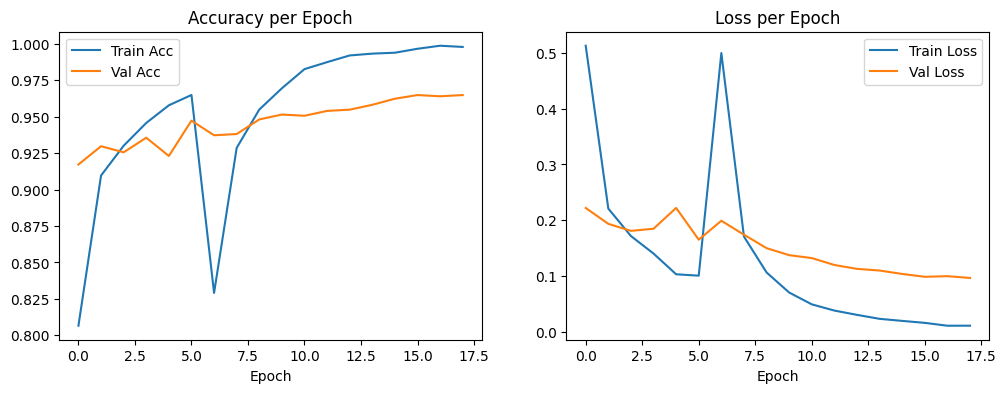

21/21 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.9635 - loss: 0.0885

=== HASIL AKHIR MINGGU 3 ===
Test Accuracy : 0.9638554453849792
Test Loss     : 0.09829175472259521

Model disimpan di: /content/drive/MyDrive/model_mobilenetv2_leaf_final.keras
Class names disimpan di: /content/drive/MyDrive/model_mobilenetv2_leaf_classes.json
Model terbaik per-epoch juga tersimpan di: /content/drive/MyDrive/model_mobilenetv2_leaf_best.keras


In [3]:
# =====================================================
# MINGGU 3 — TRAINING CNN MOBILE NET V2 & TUNING
#            + CLASS WEIGHT + CHECKPOINT + EARLY STOP
# =====================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import json

IMG_SIZE = (224, 224)

# -----------------------------
# 1. Bangun model (Feature Extraction)
# -----------------------------
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False   # Tahap 1: hanya train head

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="leaf_mobilenetv2")

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -----------------------------
# 2. CALLBACKS:
#    ModelCheckpoint + EarlyStopping
# -----------------------------
BEST_MODEL_PATH = "/content/drive/MyDrive/model_mobilenetv2_leaf_best.keras"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early_stop_stage1 = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

early_stop_stage2 = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# -----------------------------
# 3. TRAINING TAHAP 1 (Feature Extraction)
# -----------------------------
EPOCHS_STAGE1 = 6   # sesuai saran untuk datasetmu

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    class_weight=class_weights,          # 🔥 pakai class weight
    callbacks=[checkpoint, early_stop_stage1]
)

# -----------------------------
# 4. Fine-Tuning backbone (unfreeze sebagian)
# -----------------------------
base_model.trainable = True

# Freeze semua layer kecuali 40 terakhir (bisa diubah)
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),   # LR kecil untuk fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_STAGE2 = 12

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    class_weight=class_weights,          # 🔥 tetap pakai class weight
    callbacks=[checkpoint, early_stop_stage2]
)

# -----------------------------
# 5. Gabung history untuk plotting
# -----------------------------
acc = history1.history["accuracy"] + history2.history["accuracy"]
val_acc = history1.history["val_accuracy"] + history2.history["val_accuracy"]
loss = history1.history["loss"] + history2.history["loss"]
val_loss = history1.history["val_loss"] + history2.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Train Acc")
plt.plot(epochs_range, val_acc, label="Val Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.legend()

plt.show()

# -----------------------------
# 6. Evaluasi singkat di test set
#    (model sudah di-set ke bobot terbaik
#     berkat restore_best_weights)
# -----------------------------
test_loss, test_acc = model.evaluate(test_ds)
print("\n=== HASIL AKHIR MINGGU 3 ===")
print("Test Accuracy :", test_acc)
print("Test Loss     :", test_loss)

# -----------------------------
# 7. Save model & class names
#    (ini sekarang menyimpan model terbaik,
#     bukan sekadar epoch terakhir)
# -----------------------------
MODEL_PATH = "/content/drive/MyDrive/model_mobilenetv2_leaf_final.keras"
CLASSES_PATH = "/content/drive/MyDrive/model_mobilenetv2_leaf_classes.json"

model.save(MODEL_PATH)

with open(CLASSES_PATH, "w") as f:
    json.dump(class_names, f)

print("\nModel disimpan di:", MODEL_PATH)
print("Class names disimpan di:", CLASSES_PATH)
print("Model terbaik per-epoch juga tersimpan di:", BEST_MODEL_PATH)


**MINGGU 4 — Testing dan Analisis Hasil**

Model loaded!
Classes: ['potato_early_blight', 'potato_healthy', 'potato_late_blight', 'tomato_early_blight', 'tomato_healthy', 'tomato_late_blight']
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.9635 - loss: 0.0885

=== EVALUASI TEST SET ===
Test Accuracy: 0.9638554453849792
Test Loss    : 0.09829175472259521


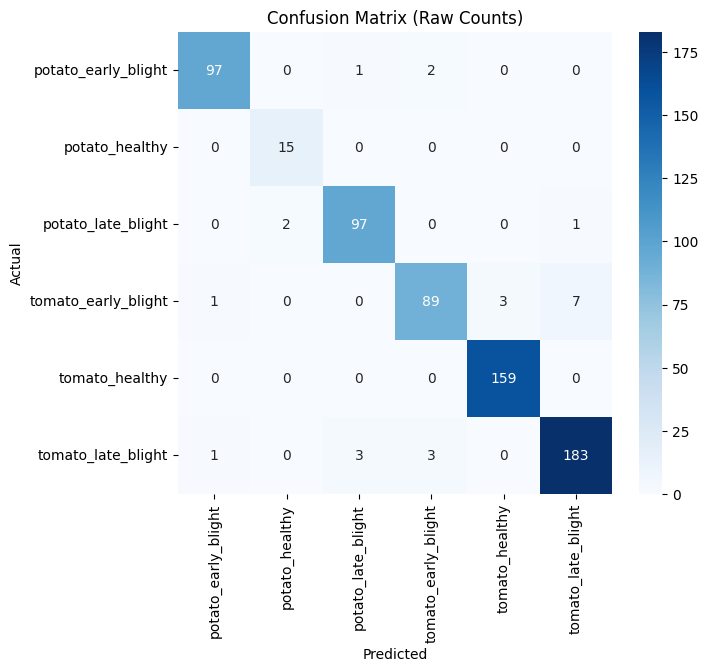


=== Classification Report ===
                     precision    recall  f1-score   support

potato_early_blight       0.98      0.97      0.97       100
     potato_healthy       0.88      1.00      0.94        15
 potato_late_blight       0.96      0.97      0.97       100
tomato_early_blight       0.95      0.89      0.92       100
     tomato_healthy       0.98      1.00      0.99       159
 tomato_late_blight       0.96      0.96      0.96       190

           accuracy                           0.96       664
          macro avg       0.95      0.97      0.96       664
       weighted avg       0.96      0.96      0.96       664



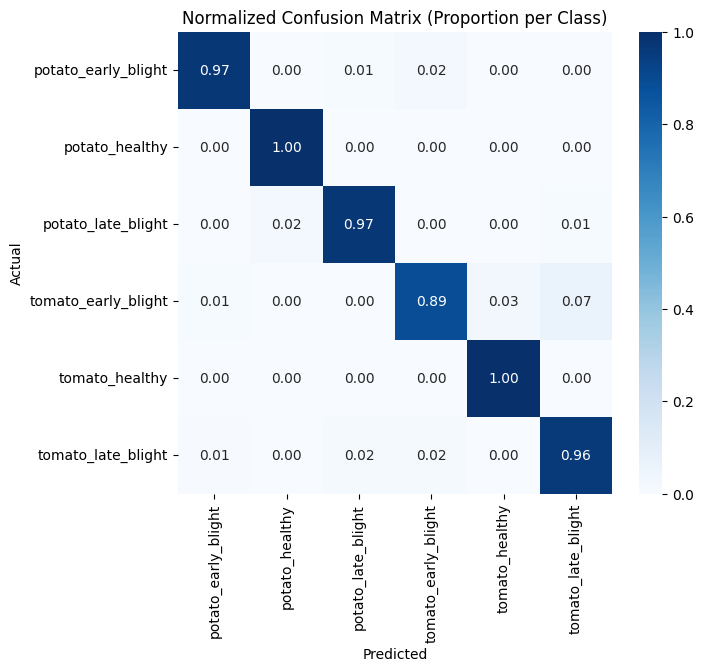

In [6]:
# =====================================================
# MINGGU 4 — TESTING, CONFUSION MATRIX, ANALISIS
#             (RAW + NORMALIZED), PREDIKSI GAMBAR
# =====================================================

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

# -----------------------------
# 1. Load model & class names
# -----------------------------
MODEL_PATH = "/content/drive/MyDrive/model_mobilenetv2_leaf_final.keras"
CLASSES_PATH = "/content/drive/MyDrive/model_mobilenetv2_leaf_classes.json"

model = keras.models.load_model(MODEL_PATH)

with open(CLASSES_PATH, "r") as f:
    class_names = json.load(f)

print("Model loaded!")
print("Classes:", class_names)

# test_ds sudah dibuat pada Minggu 2 (shuffle=False)

# -----------------------------
# 2. Evaluasi numerik
# -----------------------------
test_loss, test_acc = model.evaluate(test_ds)
print("\n=== EVALUASI TEST SET ===")
print("Test Accuracy:", test_acc)
print("Test Loss    :", test_loss)

# -----------------------------
# 3. Confusion Matrix (Raw)
# -----------------------------
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Raw Counts)")
plt.show()

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# ============================================================
# 4. NORMALIZED CONFUSION MATRIX (Per-Class Accuracy)
# ============================================================

cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (Proportion per Class)")
plt.show()



**Fungsi Prediksi Gambar (Daun Sehat vs Terinfeksi)**

Saving tomat3.jpg to tomat3 (1).jpg

Menguji: tomat3 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


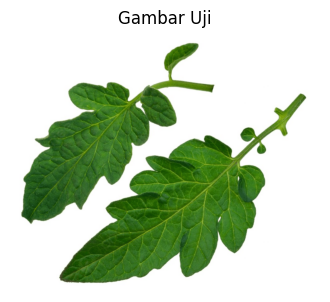

=== HASIL PREDIKSI ===
Status          : TERINFEKSI
Kelas Prediksi  : Tomato Early Blight
Confidence      : 0.498


In [7]:
# =====================================================
# FUNGSI PREDIKSI SATU GAMBAR DAUN
# =====================================================

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)

def predict_leaf(image_path):
    # Baca & resize gambar
    img = Image.open(image_path).convert("RGB")
    img_resized = img.resize(IMG_SIZE)

    # array float32 (0–255), preprocess_input sudah di dalam model
    img_array = np.array(img_resized, dtype=np.float32)
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    preds = model.predict(img_array)[0]
    pred_index = np.argmax(preds)
    confidence = preds[pred_index]
    predicted_class = class_names[pred_index]

    # Tentukan status sehat / terinfeksi
    if "healthy" in predicted_class.lower():
        status = "SEHAT"
    else:
        status = "TERINFEKSI"

    # Tampilkan gambar
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Gambar Uji")
    plt.show()

    print("=== HASIL PREDIKSI ===")
    print("Status          :", status)
    print("Kelas Prediksi  :", predicted_class.replace("_", " ").title())
    print(f"Confidence      : {confidence:.3f}")

# -----------------------------------------------------
# Upload gambar dari lokal (Colab)
# -----------------------------------------------------
from google.colab import files
uploaded = files.upload()

for fname in uploaded.keys():
    print("\nMenguji:", fname)
    predict_leaf(fname)
